In [1]:

import seaborn as sn
import fnmatch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils import data
import numpy as np
import torchvision
from  numpy import exp,absolute
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import math
from sklearn.svm import SVC 
from sklearn.neural_network import MLPClassifier as mlp
import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
from torchmetrics.functional.classification import multiclass_confusion_matrix as mcm
from sklearn.dummy import DummyClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score,f1_score,precision_score ,recall_score 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns


In [2]:
#hyper params
lr = 1e-4
wd = 1e-3
feature_extract = True
#lr = 1e-4
bs = 64
val_split = 0.85
test_split = 0.90
num_epoch = 20
classes = [0,1,15,17,2,3,4] #arranged in order of their placement in the folder
num_classes = len(classes)
path = './Irrelevant_Balanced'

In [3]:

def get_dataset(path,val_split,test_split):
    data_transforms = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=10),
        transforms.RandomCrop(size=224),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(path,transform=data_transforms)
    
    top_size = math.floor(len(dataset)*test_split)
    train_size = math.floor(len(dataset)*val_split)
    val_size = top_size - train_size
    test_size = len(dataset) - top_size
    topset,testset = data.random_split(dataset,lengths=[top_size,test_size])
    trainset,valset = data.random_split(topset,lengths=[train_size,val_size])
    
    print(len(trainset),len(valset),len(testset))
    
    return trainset,valset,testset

In [4]:
def train_model(trainset, valset, model, criterion, optimizer, scheduler, num_epochs,bs,hardness_threshold):
    dataloaders = {
        'train': data.DataLoader(trainset,batch_size=bs,shuffle=True),
        'val' : data.DataLoader(valset,batch_size=bs,shuffle=True)
    }
    dataset_sizes = {'train':len(trainset),'val':len(valset)}
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # List to store entropy values for each epoch
    entropy_values_train = []  
    entropy_values_val = []  
    #List to store loss of each epoch
    E_loss_train = []         
    E_loss_val = []
    # List to store balanced accuracy for training phase
    balanced_acc_train = []  
    balanced_acc_val = []    
    

          
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        c = 0
        all_labels = []
        all_preds = []
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            epoch_entropy = 0.0  # Variable to store epoch entropy


            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                #labels = torch.tensor(labels)
                labels = labels.to(device)
                #print(labels)

                # zero the parameter gradients
                optimizer.zero_grad()
                
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1) 

                    loss = criterion(outputs, labels)
                    
                    balanced_acc = balanced_accuracy_score(labels.cpu(), preds.cpu())  # Calculate balanced accuracy
                    
                    all_labels.extend(labels.cpu().tolist())
                    all_preds.extend(preds.cpu().tolist())

                    
                    # Calculate hardness score for each sample in the batch
                    probabilities_hard = torch.softmax(outputs, dim=1)
                    hardness_scores = 1.0 - torch.max(probabilities_hard, dim=1)[0]
                    #print('hardness score',hardness_scores)
                    
                    # Skip predictions if hardness score is greater than the threshold
                    skip_mask = hardness_scores <= hardness_threshold
                    if skip_mask.sum().item() > 0:
                        c+=1
                        inputs = inputs[skip_mask]
                        labels = labels[skip_mask]
                        preds = preds[skip_mask]
                        loss = criterion(outputs[skip_mask], labels)
                    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
                # Calculate entropy for each batch and accumulate for epoch entropy
                probabilities = torch.softmax(outputs, dim=1)
                entropy = -torch.sum(probabilities * torch.log2(probabilities + 1e-10), dim=1)
                epoch_entropy += torch.sum(entropy)

            #confusion_matrix(preds, labels)

            if phase == 'train':
                scheduler.step()
                
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            epoch_entropy /= dataset_sizes[phase]  # Calculate average epoch entropy
            
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print('{} Epoch Entropy: {:.4f}'.format(phase,epoch_entropy.item()))
            print('{} Balanced Accuracy: {:.4f}'.format(phase,balanced_acc))
            print()
            
            if phase == 'train':
                # Save epoch entropy to the list
                entropy_values_train.append(epoch_entropy.item())
                #save epoch loss in a list
                E_loss_train.append(epoch_loss)
                #save epoch balanced loss in a list
                balanced_acc_train.append(balanced_acc)  # Append balanced accuracy for training

            else:
                # Save epoch entropy to the list
                entropy_values_val.append(epoch_entropy.item())
                #save epoch loss in a list
                E_loss_val.append(epoch_loss)
                #save epoch balanced loss in a list
                balanced_acc_val.append(balanced_acc)  # Append balanced accuracy for validation

            # Confusion Matrix
            cm = confusion_matrix(all_labels, all_preds)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
            disp.plot()
            plt.figure(figsize=(8, 6))
            plt.show()
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            # Apply weight decay to the parameters after each epoch
            for param in model.parameters():
                param.data -= lr * param.grad.data + wd * param.data
                
        print('Number of skipped:',c)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    
   
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val

In [5]:
def test_model(model, testset):
    running_corrects = 0
    testloader = data.DataLoader(testset, batch_size=bs, shuffle=True)
    all_labels = []
    all_preds = []

    for inputs, labels in testloader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            running_corrects += torch.sum(preds == labels.data)
            all_labels.extend(labels.cpu().tolist())
            all_preds.extend(preds.cpu().tolist())

    test_accuracy = running_corrects / len(testset)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)

    print("The Test Accuracy:", test_accuracy)
    print("The Test Balanced Accuracy:", balanced_acc)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
    disp.plot()
    plt.figure(figsize=(8, 6))
    plt.show()


In [6]:

def weighted_score_array(models,dataset):
    num_models = len(models)
    X = np.empty((0,num_models*num_classes))
    Y = np.empty((0),dtype=int)
    dataloader = data.DataLoader(dataset,batch_size=64,shuffle=True)
    for inputs,labels in dataloader:
        inputs,labels = inputs.to(device),labels.to(device)
        predictions = set()
        with torch.set_grad_enabled(False):
            x = models[0](inputs)
            _, preds = torch.max(x, 1)
            predictions.add(preds)
            for i in range(1,num_models):
                x1 = models[i](inputs)
                _, preds = torch.max(x1, 1)
                predictions.add(preds)
                x = torch.cat((x,x1),dim=1)
            if len(predictions) > 1:
                X = np.append(X,x.cpu().numpy()*3,axis=0)
            else:
                X = np.append(X,x.cpu().numpy(),axis=0)
            Y = np.append(Y,labels.cpu().numpy(),axis=0)     
    return X,Y




In [7]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 256

    if model_name == "resnet":
        """ Resnet50
        """
        print("Resnet50")
        model_ft = models.resnet50(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(2048,num_classes)
        #num_ftrs = model_ft.fc.in_features
        #model_ft.fc = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "mobilenet":
        """ Mobilenet_V2
        """
        print("Mobilenet_V2")
        model_ft = torchvision.models.mobilenet_v2(pretrained=use_pretrained)
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
            )
            #nu        #num_features = model.classifier[1].in_features
        #model.classifier[1] = nn.Linear(num_ftrs, num_classes)

    elif model_name == "vgg":
        """ VGG16_bn
        """
        print("VGG16_bn")
        model_ft = models.vgg16(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[6] = nn.Linear(4096, num_classes)
        #num_ftrs = model_ft.classifier[6].in_features
        #model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)

    elif model_name == "googlenet":
        """ googlenet
        """
        print("VGG16_bn")
        model_ft = torchvision.models.googlenet(weights='DEFAULT')
        #set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.fc = nn.Linear(1024,num_classes)
        #model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        #model_ft.num_classes = num_classes

    elif model_name == "densenet":
        """ Densenet
        """
        print("Densenet")
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier = nn.Linear(2208,num_classes)
        #num_ftrs = model_ft.classifier.in_features
        #model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        
    elif model_name == "vit":
        """ Vision Transformer (ViT) """
        print("ViT")
        model_ft = models.vit_b_32(pretrained=use_pretrained)


    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

# Initialize the model for this run

# Print the model we just instantiated
#print(model_ft)


In [9]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
def plot_distribution_by_class(dataset, classes):
    dataloaders = data.DataLoader(dataset,batch_size=bs,shuffle=True)
    count = [0] * len(classes)  # Initialize count list with zeros

    for inputs, labels in dataloaders:
        inputs = inputs.to(device)
        labels = labels.to(device)

        
    
        for i in labels:
            count[i] += 1
    
    
    plt.figure(figsize=(10, 6))  # Set the size of the figure
    
    x = np.arange(len(classes))  # Generate an array of class indices
    plt.bar(x, count)
    plt.xticks(x, classes)  # Set custom x-axis tick positions and labels
    plt.xlabel("Classes")
    plt.ylabel("Count")
    plt.title("Class Count")
    plt.show()

In [11]:
# Setup the loss function
criterion = nn.CrossEntropyLoss()

# Separate the train, val, and test sets
trainset, valset, testset = get_dataset(path, val_split, test_split)

16040 943 1888


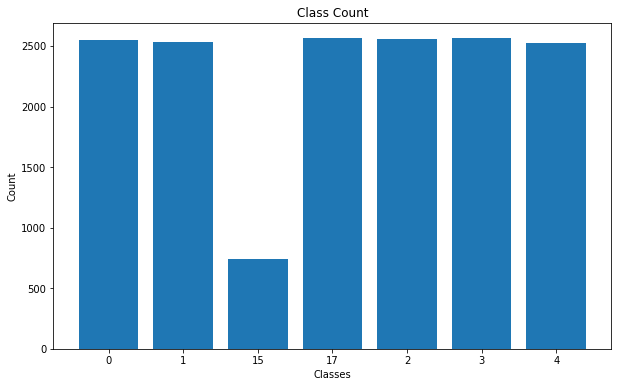

In [14]:
plot_distribution_by_class(trainset, classes)

Resnet50


/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/rishav/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.0.conv3.weight
	 layer1.0.bn3.weight
	 layer1.0.bn3.bias
	 layer1.0.downsample.0.weight
	 layer1.0.downsample.1.weight
	 layer1.0.downsample.1.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer1.1.conv3.weight
	 layer1.1.bn3.weight
	 layer1.1.bn3.bias
	 layer1.2.conv1.weight
	 layer1.2.bn1.weight
	 layer1.2.bn1.bias
	 layer1.2.conv2.weight
	 layer1.2.bn2.weight
	 layer1.2.bn2.bias
	 layer1.2.conv3.weight
	 layer1.2.bn3.weight
	 layer1.2.bn3.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.conv3.weight
	 layer2.0.bn3.weight
	 layer2.0.bn3.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight

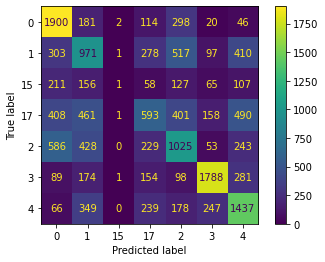

<Figure size 576x432 with 0 Axes>

val Loss: 1.2807 Acc: 0.5122
val Epoch Entropy: 1.8944
val Balanced Accuracy: 0.4210



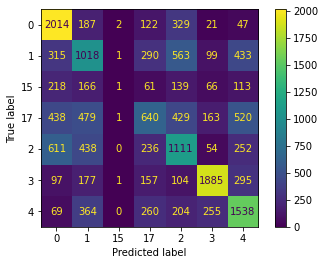

<Figure size 576x432 with 0 Axes>

Number of skipped: 265

Epoch 1/19
----------
train Loss: 1.2578 Acc: 0.5208
train Epoch Entropy: 1.8367
train Balanced Accuracy: 0.4976



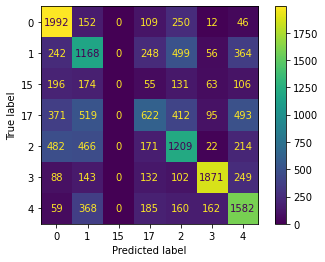

<Figure size 576x432 with 0 Axes>

val Loss: 1.2601 Acc: 0.5217
val Epoch Entropy: 1.7926
val Balanced Accuracy: 0.5215



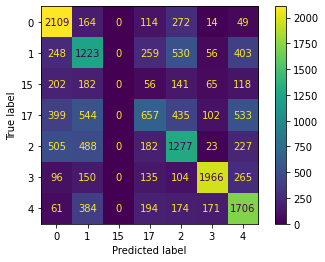

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 2/19
----------
train Loss: 1.2165 Acc: 0.5305
train Epoch Entropy: 1.7974
train Balanced Accuracy: 0.4606



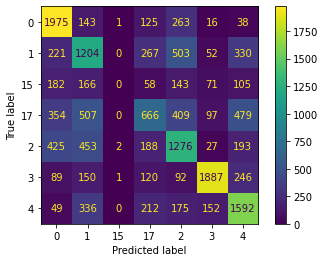

<Figure size 576x432 with 0 Axes>

val Loss: 1.2614 Acc: 0.5196
val Epoch Entropy: 1.7131
val Balanced Accuracy: 0.3984



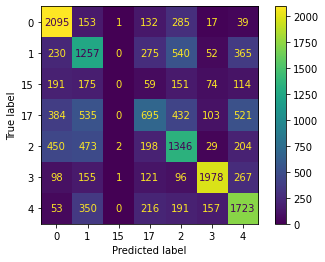

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 3/19
----------
train Loss: 1.1982 Acc: 0.5368
train Epoch Entropy: 1.7729
train Balanced Accuracy: 0.4548



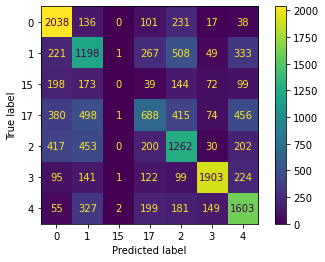

<Figure size 576x432 with 0 Axes>

val Loss: 1.2755 Acc: 0.5249
val Epoch Entropy: 1.7662
val Balanced Accuracy: 0.4600



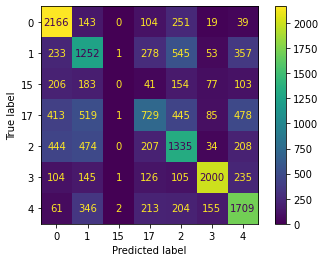

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 4/19
----------
train Loss: 1.1744 Acc: 0.5439
train Epoch Entropy: 1.7450
train Balanced Accuracy: 0.4831



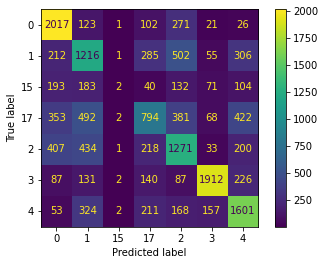

<Figure size 576x432 with 0 Axes>

val Loss: 1.3160 Acc: 0.5101
val Epoch Entropy: 1.7080
val Balanced Accuracy: 0.4371



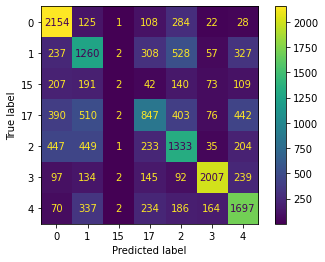

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 5/19
----------
train Loss: 1.1688 Acc: 0.5514
train Epoch Entropy: 1.7249
train Balanced Accuracy: 0.5185



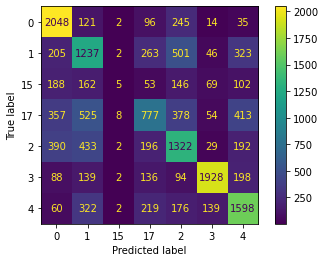

<Figure size 576x432 with 0 Axes>

val Loss: 1.2665 Acc: 0.5334
val Epoch Entropy: 1.6904
val Balanced Accuracy: 0.4340



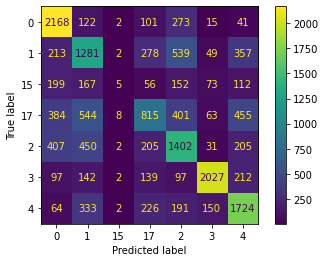

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 6/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 1.1504 Acc: 0.5592
train Epoch Entropy: 1.7059
train Balanced Accuracy: 0.5600



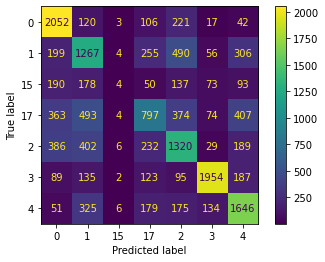

<Figure size 576x432 with 0 Axes>

val Loss: 1.2758 Acc: 0.5228
val Epoch Entropy: 1.6449
val Balanced Accuracy: 0.5513



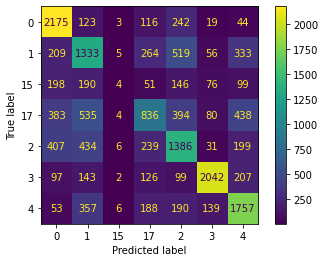

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 7/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 1.0504 Acc: 0.5937
train Epoch Entropy: 1.6682
train Balanced Accuracy: 0.6017



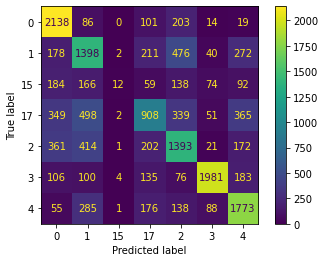

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.2681 Acc: 0.5270
val Epoch Entropy: 1.6235
val Balanced Accuracy: 0.4530



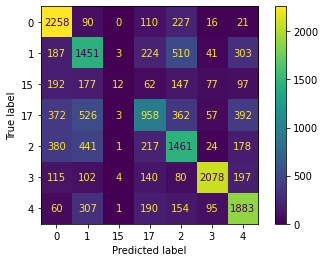

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 8/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.9913 Acc: 0.6206
train Epoch Entropy: 1.5930
train Balanced Accuracy: 0.5739



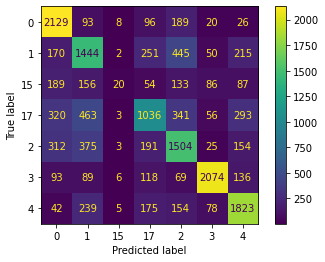

<Figure size 576x432 with 0 Axes>

val Loss: 1.2964 Acc: 0.5292
val Epoch Entropy: 1.5701
val Balanced Accuracy: 0.4790



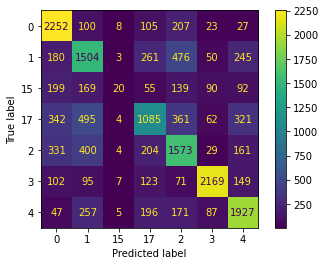

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 9/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.9500 Acc: 0.6392
train Epoch Entropy: 1.5357
train Balanced Accuracy: 0.4522



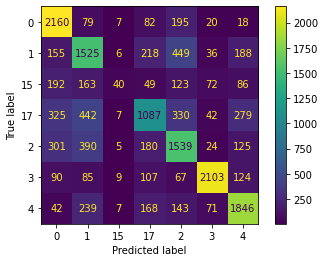

<Figure size 576x432 with 0 Axes>

val Loss: 1.3089 Acc: 0.5260
val Epoch Entropy: 1.5309
val Balanced Accuracy: 0.4293



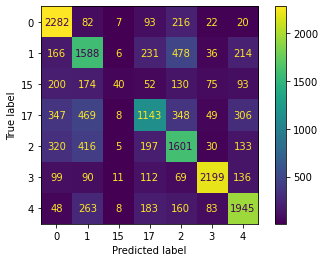

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 10/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.9131 Acc: 0.6549
train Epoch Entropy: 1.4758
train Balanced Accuracy: 0.5197



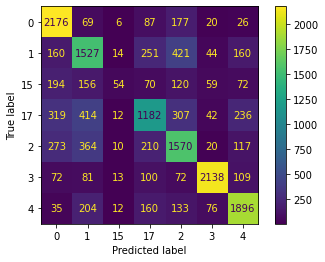

<Figure size 576x432 with 0 Axes>

val Loss: 1.3624 Acc: 0.5313
val Epoch Entropy: 1.4547
val Balanced Accuracy: 0.6653



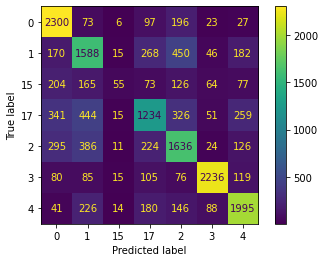

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 11/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.8724 Acc: 0.6766
train Epoch Entropy: 1.4358
train Balanced Accuracy: 0.6012



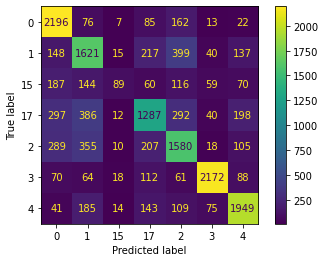

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3569 Acc: 0.5186
val Epoch Entropy: 1.4669
val Balanced Accuracy: 0.4597



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


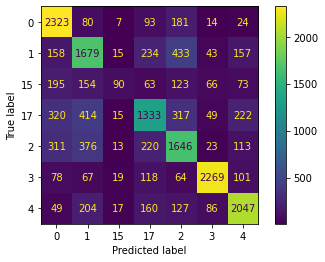

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 12/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.8222 Acc: 0.6936
train Epoch Entropy: 1.3828
train Balanced Accuracy: 0.6864



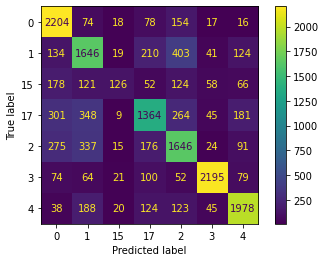

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.3914 Acc: 0.5217
val Epoch Entropy: 1.4028
val Balanced Accuracy: 0.2830



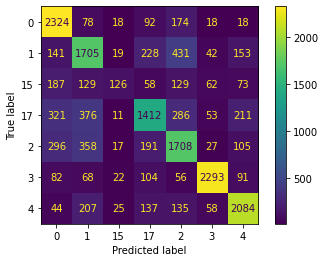

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 13/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.7750 Acc: 0.7186
train Epoch Entropy: 1.3189
train Balanced Accuracy: 0.7031



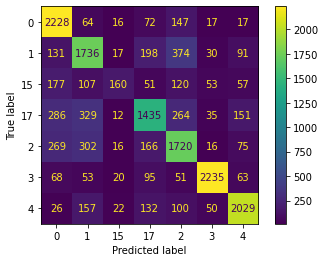

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4498 Acc: 0.5080
val Epoch Entropy: 1.3576
val Balanced Accuracy: 0.5298



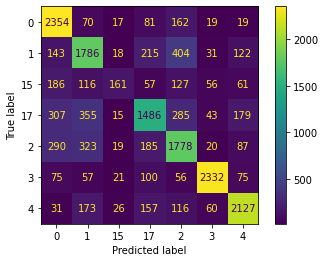

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 14/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.7112 Acc: 0.7472
train Epoch Entropy: 1.2806
train Balanced Accuracy: 0.7500



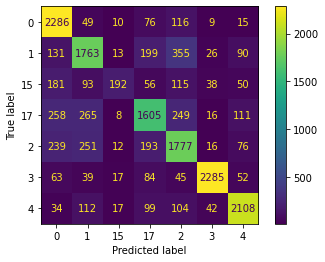

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4351 Acc: 0.5196
val Epoch Entropy: 1.3765
val Balanced Accuracy: 0.4198



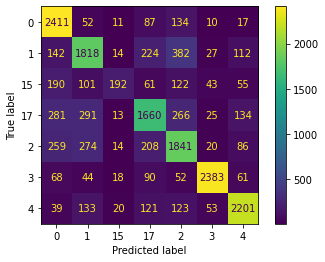

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 15/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6976 Acc: 0.7519
train Epoch Entropy: 1.2729
train Balanced Accuracy: 0.6911



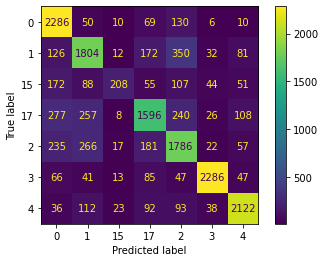

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4793 Acc: 0.5058
val Epoch Entropy: 1.3667
val Balanced Accuracy: 0.6139



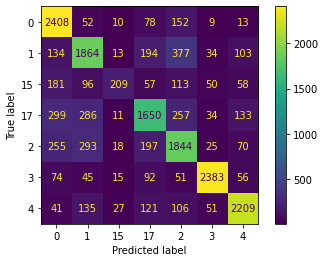

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 16/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.6913 Acc: 0.7552
train Epoch Entropy: 1.2689
train Balanced Accuracy: 0.7707



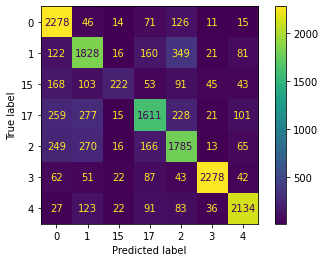

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4463 Acc: 0.5175
val Epoch Entropy: 1.3833
val Balanced Accuracy: 0.4494



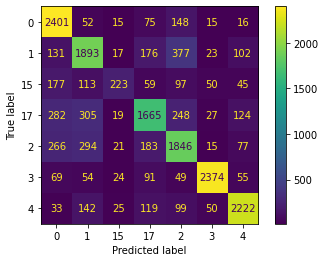

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 17/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.6866 Acc: 0.7541
train Epoch Entropy: 1.2632
train Balanced Accuracy: 0.6859



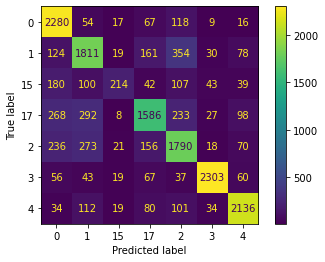

<Figure size 576x432 with 0 Axes>

/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


val Loss: 1.4867 Acc: 0.5048
val Epoch Entropy: 1.3803
val Balanced Accuracy: 0.5315



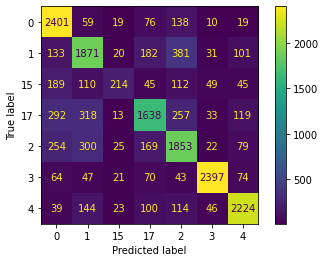

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 18/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rish

train Loss: 0.6786 Acc: 0.7601
train Epoch Entropy: 1.2592
train Balanced Accuracy: 0.8104



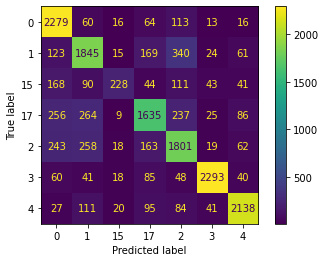

<Figure size 576x432 with 0 Axes>

val Loss: 1.4936 Acc: 0.5027
val Epoch Entropy: 1.3775
val Balanced Accuracy: 0.5094



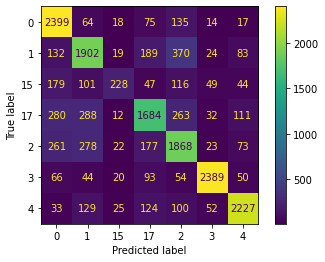

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Epoch 19/19
----------


/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


train Loss: 0.6700 Acc: 0.7629
train Epoch Entropy: 1.2486
train Balanced Accuracy: 0.7713



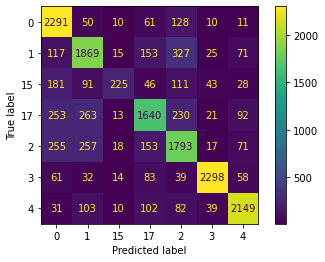

<Figure size 576x432 with 0 Axes>

val Loss: 1.4850 Acc: 0.5058
val Epoch Entropy: 1.3698
val Balanced Accuracy: 0.6017



/home/rishav/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2184: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


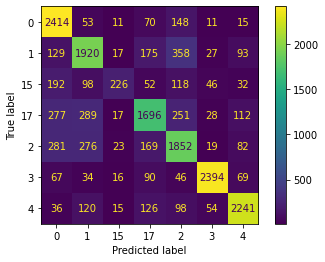

<Figure size 576x432 with 0 Axes>

Number of skipped: 266

Training complete in 34m 8s
Best val Acc: 0.533404
The Test Accuracy: tensor(0.5249, device='cuda:0')
The Test Balanced Accuracy: 0.48260413222063103


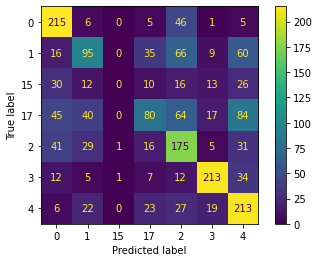

<Figure size 576x432 with 0 Axes>

None


In [13]:
model_list = []
hardness_threshold = 0.75
for model_name in ["resnet"]:
    
    # Initialize the model
    model, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)
    
    model_list.append(model)
    
    # Send model to GPU, if available
    model = model.to(device)
    
    params_to_update = model.parameters()
    
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name, param in model.named_parameters():
            if param.requires_grad:
                params_to_update.append(param)
                print("\t", name)
    else:
        for name, param in model.named_parameters():
            if param.requires_grad:
                print("\t", name)
    
    # Observe that all parameters are being optimized
    optimizer = optim.Adam(params_to_update, lr=lr, weight_decay=wd)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    
    model, entropy_values_train, entropy_values_val, E_loss_train, E_loss_val, balanced_acc_train, balanced_acc_val = train_model(trainset, valset, model, criterion, optimizer, exp_lr_scheduler, num_epoch, bs,hardness_threshold)
    
    print(test_model(model, testset))





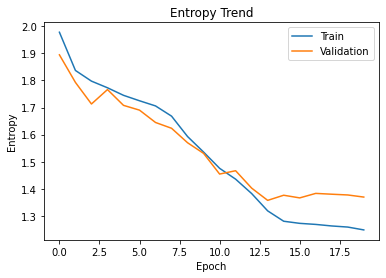

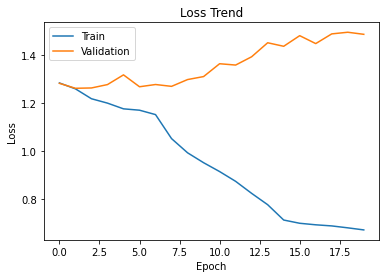

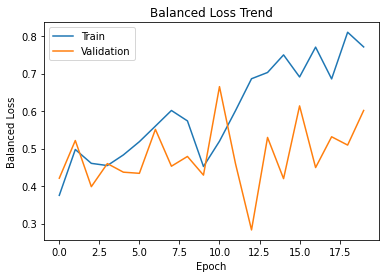

In [15]:

import matplotlib.pyplot as plt

# Plot entropy values
plt.figure()
plt.plot(entropy_values_train, label='Train')
plt.plot(entropy_values_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Entropy')
plt.title('Entropy Trend')
plt.legend()
plt.show()

# Plot loss values
plt.figure()
plt.plot(E_loss_train, label='Train')
plt.plot(E_loss_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend')
plt.legend()
plt.show()

# Plot balanced loss values
plt.figure()
plt.plot(balanced_acc_train, label='Train')
plt.plot(balanced_acc_val, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Balanced Loss')
plt.title('Balanced Loss Trend')
plt.legend()
plt.show()


In [16]:
    
train_X, train_Y = weighted_score_array(model_list, trainset)
test_X, test_Y = weighted_score_array(model_list, testset)

#make a dummy prediction, i.e Random Baseline
# Create a dummy classifier with a strategy
dummy_clf = DummyClassifier(strategy='uniform')

# Train the dummy classifier
dummy_clf.fit(train_X, train_Y)

# Make predictions on the test set
predictions = dummy_clf.predict(test_X)

# Evaluate the accuracy of the dummy classifier
accuracy = dummy_clf.score(test_X, test_Y)

print("Dummy Classifier Accuracy/ Random Baseline:", accuracy)

Dummy Classifier Accuracy/ Random Baseline: 0.1371822033898305


Accuracy for SVM: 0.5233050847457628
Balanced Accuracy:0.4832217756157172


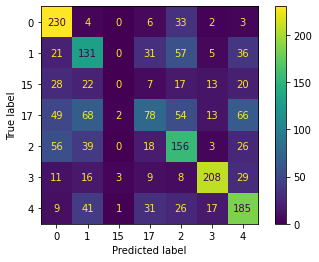

<Figure size 576x432 with 0 Axes>

In [17]:
    
# Predict using SVM
model_svc = SVC(decision_function_shape='ovr', C=500, kernel='rbf')
model_svc.fit(train_X, train_Y)
pred = model_svc.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for SVM: ' + str(acc))
balanced_svm = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_svm))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()

Accuracy for MLP: 0.5058262711864406
Balanced Accuracy:0.46757952818977444


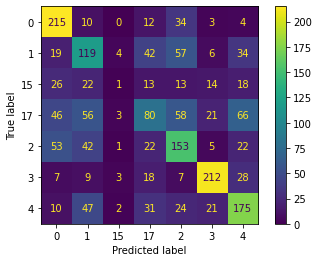

<Figure size 576x432 with 0 Axes>

In [18]:
# Predict using MLP
model_mlp = mlp(solver='lbfgs', alpha=1e-5, random_state=5, max_iter=100000)
model_mlp.fit(train_X, train_Y)
pred = model_mlp.predict(test_X)
acc = accuracy_score(test_Y, pred)
print('Accuracy for MLP: ' + str(acc))
balanced_mlp = balanced_accuracy_score(test_Y, pred)  # Calculate balanced accuracy
print("Balanced Accuracy:"+ str(balanced_mlp))
# Confusion Matrix
cm = confusion_matrix(test_Y, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=classes )
disp.plot()
plt.figure(figsize=(8, 6))
plt.show()